# Q value of Parallel RLC circuit

Consider an Parallel LC circuit capacitively coupled to a resistor.
With capacitance $C$, inductance $L$, coupling capacitance $C_g$ and
dispassion by outgoing transmission line with characteristic impendence $Z_0$.

The transmission line is equivalent to dispassion with resistor $R$ in series to circuits.

The input impendance of the whole circuit is 
$$
\frac{1}{Z_{\mathrm{in}}} = \frac{1}{i\omega L} +i\omega C+\frac{1}{\frac{1}{i\omega C_{g}} +R}
$$

We care about the resonance frequency $\omega_0$ and quality factor $Q$. 
Of course we can reduce the formula into a form like that of parallel RLC circuit 
such that we can solve these analytically.

Here we prefer an numerical method which can be applied to more general circuit.
At resonance, the imaginary part of input disappears, 
and the derivative there shows the equivalent "mass" of resonator, here is $2C^\prime$.
With that, we can calculat the Q value with $Q = \omega_0 R C$.

So we calculate the input impendence (actually the inverse $Z_\mathrm{in}^{-1}$) 
versus the probe frequency $\omega$.

**Besides, This notebooks serves as an practical example for constructing a labcode.Calculator.**

Unperturbed freq is 3.751 GHz
Q is 0.3080 million, freq shift is -10.377 MHz


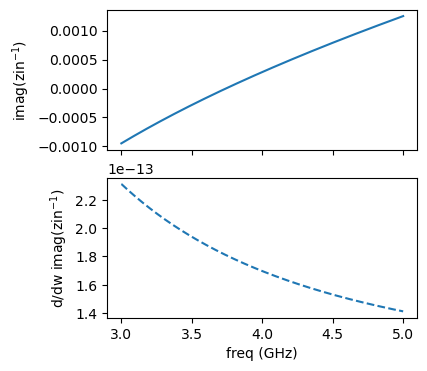

In [1]:
import numpy as np
import matplotlib.pyplot as plt

L = 20e-9
C = 90e-15
w00 = 1/np.sqrt(L * C)  # Unperturbed frequency.
print(f"Unperturbed freq is {w00/(2*np.pi)/1e9:.3f} GHz")

w = np.linspace(3e9, 5e9, 1001) * 2 * np.pi
Cg = 0.5e-15
R = 50
zin_inv = 1/(1j*w*L) + 1j*w*C + 1/(1/(1j*w*Cg) + R)

fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(4,4))
ax.plot(w/2/np.pi/1e9, zin_inv.imag)
ax2.plot(w/2/np.pi/1e9, np.gradient(zin_inv.imag, w[1] - w[0]), '--')
ax.set_ylabel("imag(zin$^{-1}$)")
ax2.set_ylabel("d/dw imag(zin$^{-1}$)")
ax2.set_xlabel("freq (GHz)")

# Caution! np.interp(x, xp, yp) requires xp to be monotonic increasing.
w0 = np.interp(0, zin_inv.imag, w)
Cp = np.interp(w0, w, np.gradient(zin_inv.imag, w[1] - w[0])) / 2
Rp = 1 / np.interp(w0, w, zin_inv.real)
Q = w0 * Rp * Cp
print(f"Q is {Q/1e6:.4f} million, freq shift is {(w0-w00)/1e6/2/np.pi:.3f} MHz")

The result looks resonable.

As we know that the oscillation frequency $\omega_0$ should be shifted by the coupling.
It decreases with the coupling capacitance $C_g$.

The Q value should decreases with the coupling capacitance $C_g$.

Next let's check our calculatio against these conclusion.

But before let's try to wrap this into a `labcodes.Calculator` for more covenient manipulation.

Unperturbed freq is 3.751 GHz
Q is 0.3080 million, freq shift is -10.377 MHz


(<Figure size 400x400 with 2 Axes>,
 <AxesSubplot: ylabel='imag(zin$^{-1}$)'>,
 <AxesSubplot: xlabel='freq (GHz)', ylabel='d/dw imag(zin$^{-1}$)'>)

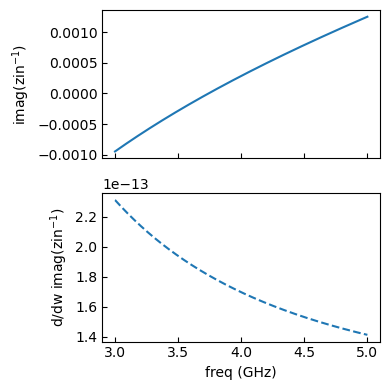

In [3]:
from labcodes.calc import Calculator, dept

class LC_CCoupled(Calculator):
    L = 20e-9
    C = 90e-15
    # Must be array with evenly spaced points.
    w = np.linspace(3e9, 5e9, 1001) * 2 * np.pi
    Cg = 0.5e-15
    R = 50

    @dept
    def w00(self, L, C):
        return 1 / np.sqrt(L * C)

    @dept
    def zin_inv(self, w, L, C, Cg, R):
        return 1 / (1j * w * L) + 1j * w * C + 1 / (1 / (1j * w * Cg) + R)

    @dept
    def w0(self, zin_inv, w):
        return np.interp(0, zin_inv.imag, w)

    @dept
    def Cp(self, w0, w, zin_inv):
        return np.interp(w0, w, np.gradient(zin_inv.imag, w[1] - w[0])) / 2

    @dept
    def Rp(self, w0, w, zin_inv):
        return 1 / np.interp(w0, w, zin_inv.real)

    @dept
    def Q(self, w0, Rp, Cp):
        return w0 * Rp * Cp

    @dept
    def freq_shift(self, w0, w00):
        return (w0 - w00) / 2 / np.pi

    def demo(self):
        freq_GHz = self.w / 2 / np.pi / 1e9
        zin_inv = self.zin_inv()

        fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(4, 4))
        ax.plot(freq_GHz, zin_inv.imag)
        ax2.plot(freq_GHz, np.gradient(zin_inv.imag, self.w[1] - self.w[0]), "--")
        ax.set_ylabel("imag(zin$^{-1}$)")
        ax2.set_ylabel("d/dw imag(zin$^{-1}$)")
        ax2.set_xlabel("freq (GHz)")
        return fig, ax, ax2

    def describe(self):
        w00 = self["w00"]
        w0 = self["w0"]
        Q = self["Q"]
        print(f"Unperturbed freq is {w00/(2*np.pi)/1e9:.3f} GHz")
        print(f"Q is {Q/1e6:.4f} million, freq shift is {(w0-w00)/1e6/2/np.pi:.3f} MHz")

lc = LC_CCoupled()
lc.describe()
lc.demo()

Then let's see how things changs with $C_g$

Text(0.5, 0, 'Cg (fF)')

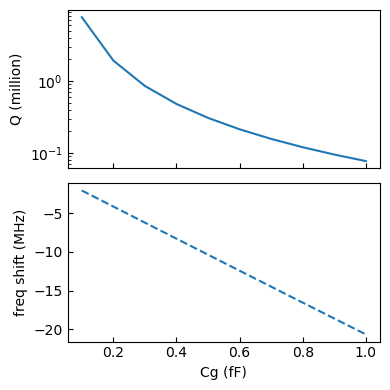

In [4]:
c_list = np.linspace(0.1e-15, 1e-15, 10)
lc_list = [LC_CCoupled(Cg=c) for c in c_list]
Q_list = np.array([lc['Q'] for lc in lc_list])
freq_shift_list = np.array([lc['freq_shift'] for lc in lc_list])

fig, (ax, ax2) = plt.subplots(nrows=2, figsize=(4,4), sharex=True)
ax.plot(c_list/1e-15, Q_list/1e6, label="Q")
ax.set_ylabel("Q (million)")
ax.set_yscale("log")
ax2.plot(c_list/1e-15, freq_shift_list/1e6, '--', label="freq shift (MHz)")
ax2.set_ylabel("freq shift (MHz)")
ax2.set_xlabel("Cg (fF)")

Another interesting observation is: with same capacitance configuration, 
the higher the oscillation frequency $\omega_0$ is (hence lower the inductance $L$), the larger the frequency shifts.

This matches with the example for high order standing modes of a $\lambda/2$ open ended transmission line resonator in Pozar_2012 Example 6.6, 
where the frequency shifts larger for higher modes.

Text(0.5, 0, 'L (nH)')

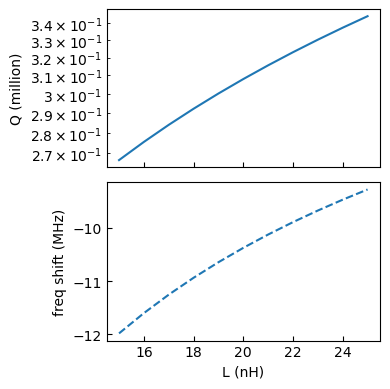

In [5]:
l_list = np.linspace(15e-9, 25e-9, 11)
lc_list = [LC_CCoupled(L=l) for l in l_list]
Q_list = np.array([rlc['Q'] for rlc in lc_list])
freq_shift_list = np.array([rlc['freq_shift'] for rlc in lc_list])

fig, (ax, ax2) = plt.subplots(nrows=2, figsize=(4,4), sharex=True)
ax.plot(l_list/1e-9, Q_list/1e6, label="Q")
ax.set_ylabel("Q (million)")
ax.set_yscale("log")
ax2.plot(l_list/1e-9, freq_shift_list/1e6, '--', label="freq shift (MHz)")
ax2.set_ylabel("freq shift (MHz)")
ax2.set_xlabel("L (nH)")